In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/멀티캠퍼스/팀프로젝트/Idiom Classifier/data/

/content/drive/MyDrive/Colab Notebooks/멀티캠퍼스/팀프로젝트/Idiom Classifier/data


In [ ]:
!nvidia-smi

Thu Oct  7 16:44:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **⦁ GPT** 구조

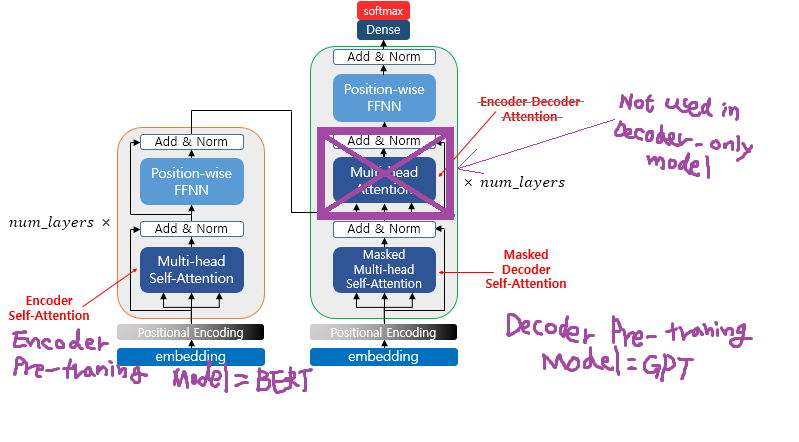

<br/><br/>

# **KoGPT2를 이용한 감성분석**
<br/>


### 1. 라이브러리 설치 및 임포트

In [ ]:
!pip install --upgrade mxnet>=1.6.0
!pip install gluonnlp
!pip install transformers
!pip install sentencepiece

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer, SentencepieceDetokenizer
from transformers import TFGPT2LMHeadModel
import tensorflow as tf

import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from tqdm import tqdm
import matplotlib.pyplot as plt


     |████████████████████████████████| 344 kB 8.1 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595747 sha256=f82ccda8a2acfd2d515f809dab0feebb49c854384be4ab340378ba610c39c021
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 2.9 MB 6.8 MB/s 
     |████████████████████████████████| 895 kB 50.4 MB/s 
     |████████████████████████████████| 3.3 MB 53.9 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 596 kB 39.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 7.9 MB/s 


In [ ]:
# oversampling을 위한 라이브러리 import - 설치도 해줄것!
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


<br/><br/>
### 2. pickle을 이용해 관용구문장(34614개)과 비관용구문장(30000개) 읽어오기 및 변수에 담기

In [ ]:
import pickle
#with open('./final_idiom_dataset_for_ko.pkl', 'rb') as f:
with open('./3/train_34614.pkl','rb') as f:
  corpus = pickle.load(f)
with open('./3/no_idiom_30000.pkl','rb') as f:
  no_idiom = pickle.load(f)

In [ ]:
# 관용구 문장만 가져와서 변수에 저장
corpus = corpus[corpus['Label']==1]
len(corpus), len(no_idiom)

(17307, 30000)

In [ ]:
no_idiom.head()

,ko,Label
0,최창식 구청장은 “동대문디자인플라자 완공에 맞춰 이 지역 일대의 간판을 깨끗이 정비...,0
1,그와 함께 있는 것 자체가 행운이었습니다.,0
2,한국관광공사는 공사가 유치한 ‘홍콩 프루덴셜’ 임직원 1800명이 인센티브 관광 목...,0
3,새로운 그대가 나에게 환하게 웃고 있군요.,0
4,"이해관계가 걸린 법안 로비 성격을 전혀 띠지 않았으나, 이 가운데 일부는 2014년...",0


In [ ]:
corpus.head()

,ko,Label
0,그럼에도 불구하고 올림픽에서 가장 멋진 부분 중 하나는 바로 사진입니다.,1
4,이 자리에서 이 대표는 “일자리 문제가 어려운데 당에서도 민생연석회의 출범을 조만간...,1
5,"한국이 당면한, 현대 한국의 정체성과 상처를 상징하는 특수한 것은 다름 아닌 ‘휴전...",1
6,전국 정부출연연구기관 지역조직 57개 관계자들이 지난 3월 6일 한자리 모여 지역혁...,1
8,내 휴가는 물 건너가는구나.,1


In [ ]:
new_df = pd.concat([corpus, no_idiom])
new_df = new_df.sample(frac=1)
new_df.reset_index(drop=True, inplace=True)

In [ ]:
new_df

,ko,Label
0,안희정 성폭력사건 공동대책위원회 소속 회원들이 안희정 전 충남지사의 항소심 첫 재판...,0
1,그런 말도 안 되는 이야기는 어디에서 듣고 오는 거야?,1
2,관객들은 “사과하라”는 구호를 외쳤고 결국 산이 소속사 사장인 래퍼 라이머가 공연을...,0
3,"또한, 이 항구는 일본과의 거리가 짧아 발진 기지로 활용하기도 좋았다.",0
4,"다행히 수술에 성공해 기적적으로 병마를 물리치는 듯했으나, 이왕표는 지난해 암이 재...",1
...,...,...
47302,김학범 감독이 이끄는 한국 23세 이하(U-23) 축구대표팀과 박항서 감독의 베트남...,0
47303,여배우에 대한 악의적 내용을 담은 허위 기사 작성 혐의로 실형이 선고된 개그맨 출신...,0
47304,전문가들은 ‘제2의 사춘기’로 불리는 여성 갱년기를 극복하기 위해서는 중년은 시들어...,1
47305,금 부회장은 올해 상반기까지 한화그룹의 컨트롤타워인 경영기획실을 이끌었지만 지난 7...,1


In [ ]:
#text.head()

In [ ]:
#data = text['ko']
#data.head()

In [ ]:
#target = text['Label']
#target.head()

In [ ]:
#type(data)

In [ ]:
type(new_df)

pandas.core.frame.DataFrame

<br/><br/> 
### 오버샘플링


In [ ]:
# train, test 분리하는 작업 - train/val/test를 먼저 분리한 다음에 train에만 oversampling을 적용!
train, test = train_test_split(new_df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.1, random_state=42)

In [ ]:
# oversampling 하는 코드
oversample = RandomOverSampler()
ko_t = train.ko.to_numpy().reshape(-1, 1) # to_numpy()로 해줘야함
label_t = train.Label.to_numpy().reshape(-1, 1)

x_over, y_over = oversample.fit_resample(ko_t, label_t)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# x_over, y_over 개수가 동일해진걸 확인할 수 있음
len(x_over), len(y_over)

(43352, 43352)

In [ ]:
# oversampling한 걸로 데이터프레임 다시 구성
#train = pd.DataFrame({'ko':x_over.reshape(-1),
#                      'Label':y_over.reshape(-1)})

<br/><br/> 
### 오버샘플링된 data/target(lable) 분리

In [ ]:
#! oversampling한 걸로 데이터프레임 다시 구성
data = pd.DataFrame({'ko':x_over.reshape(-1)})
target = pd.DataFrame({'Label':y_over.reshape(-1)})

In [ ]:
#!
data = data['ko']
target = target['Label']

In [ ]:
len(data), len(target)

(43214, 43214)

In [ ]:
### train dataset 구성
'''dataset = []
for text, label in zip(train.ko.to_list(), train.Label.to_list()):
  dataset.append([text, label])
dataset_train = dataset[:].copy()'''

'dataset = []\nfor text, label in zip(train.ko.to_list(), train.Label.to_list()):\n  dataset.append([text, label])\ndataset_train = dataset[:].copy()'

In [ ]:
### validation dataset 구성
'''dataset_val = []
for text, label in zip(val.ko.to_list(), val.Label.to_list()):
  dataset_val.append([text, label])'''

'dataset_val = []\nfor text, label in zip(val.ko.to_list(), val.Label.to_list()):\n  dataset_val.append([text, label])'

In [ ]:
###
#len(dataset_train), len(dataset_val)

<br/><br/>
### pre-training 


In [ ]:
dx_train,dx_test, dy_train, dy_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)


In [ ]:

MY_PATH = '/content/drive/MyDrive/Colab Notebooks/멀티캠퍼스/팀프로젝트/Idiom Classifier/4.KoGPT2/'
MODEL_PATH = MY_PATH + 'gpt_ckpt'
TOKENIZER_PATH = MY_PATH + 'gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH, num_best=0, alpha=0)
detokenizer = SentencepieceDetokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token = None,
                                               sep_token = None,
                                               cls_token = None,
                                               unknown_token = '<unk>',
                                               padding_token = '<pad>',
                                               bos_token = '<s>',
                                               eos_token = '</s>')
# vocab --> Vocab(size=50000, unk="<unk>", reserved="['<pad>', '<s>', '</s>']")


In [ ]:
MAX_LEN = 60
def build_data(x_data, y_label):
    data_sents = []
    data_labels = []

    for sent, label in zip(x_data, y_label):
        tokenized_text = vocab[tokenizer(sent)]

        tokens = [vocab[vocab.bos_token]]
        tokens += pad_sequences([tokenized_text], 
                                MAX_LEN, 
                                value=vocab[vocab.padding_token], 
                                padding='post').tolist()[0] 
        tokens += [vocab[vocab.eos_token]]

        data_sents.append(tokens)
        data_labels.append(label)

    return np.array(data_sents, dtype=np.int64), np.array(data_labels, dtype=np.int64).reshape(-1, 1)


In [ ]:
x_train, y_train = build_data(dx_train, dy_train)
x_test, y_test = build_data(dx_test, dy_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape


((34681, 62), (34681, 1), (8671, 62), (8671, 1))

In [ ]:
x_train

array([[    0, 11327,  3226, ...,     3,     3,     1],
       [    0,  2724, 23428, ...,     3,     3,     1],
       [    0,  3782,  1224, ...,     3,     3,     1],
       ...,
       [    0,   263,  1146, ...,     3,     3,     1],
       [    0,  2348,   831, ...,     3,     3,     1],
       [    0,  2057, 47647, ...,     3,     3,     1]])

In [ ]:
x_test[0]


array([    0,   647, 48320, 46807,  6023,  2801, 20323,  1096,  3218,
         106,  3253, 47453,   250,  3218,   286,  3253, 47453,   250,
       12527, 19261,  1703,   396,  7896,   115, 47440,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     1])

In [ ]:
len(x_test[0])

62

In [ ]:
print(len(vocab))
print(vocab.padding_token, ':', vocab[vocab.padding_token])
print(vocab.bos_token, ': ', vocab[vocab.bos_token])
print(vocab.eos_token, ': ', vocab[vocab.eos_token])
print(vocab.unknown_token, ': ', vocab[vocab.unknown_token])


50000
<pad> : 3
<s> :  0
</s> :  1
<unk> :  5


In [ ]:
word2idx = {k:v for k, v in vocab.token_to_idx.items()}
idx2word = {v:k for k, v in word2idx.items()}
idx2word[5000]


'▁전세'

In [ ]:
# 참고 : https://nlp.gluon.ai/api/modules/data.html
tokenizer('나는 자연어처리를 공부하고 있다')

print([idx2word[i] for i in x_test[0]])

['<s>', '▁사실상', '▁단기', '▁매매', '를', '▁부추', '기는', '▁것이라', '▁장기적인', '▁기업가치', '▁개선이', '▁목', '적인', '▁‘', '스', '튜', '어드', '십', '▁코드', '(', '기관', '투자가', '의', '▁적극적', '▁의결권', '▁행사', '▁지침', ')’', '▁도입', '▁취', '지와', '▁맞지', '▁않는다는', '▁지적도', '▁있다', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '</s>']


In [ ]:
gpt_model = TFGPT2LMHeadModel.from_pretrained(MODEL_PATH)
gpt_model.summary()


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/멀티캠퍼스/팀프로젝트/Idiom Classifier/4.KoGPT2/gpt_ckpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 124,242,432
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#pre-trainmodel
# TFGPT2MainLayer는 fine-tuning을 하지 않는다.
gpt_model.trainable = True
gpt_model.summary() # gtp_model을 다시 확인한다. trainable params = 0


Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 124,242,432
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# GPT2 입력
# ---------
x_input = Input(batch_shape = (None, MAX_LEN + 2), dtype = tf.int32)


In [ ]:
# GPT2 출력
# ---------
# output_gpt[0]        --> <KerasTensor: shape=(None, 60, 50000) dtype=float32
# output_gpt[0][:, -1] --> <KerasTensor: shape=(None, 50000) dtype=float32
output_gpt = gpt_model(x_input)[0][:, -1]


In [ ]:
# Downstream task : idiom classifier
# -------------------------------------
# 사전학습데이터 없이 Dense Layer만 붙여놓은것
y_output = Dense(1, activation = 'sigmoid')(output_gpt)
model = Model(x_input, y_output)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 2e-5))
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
tfgp_t2lm_head_model (TFGPT2 TFCausalLMOutputWithPast( 124242432 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 50000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 50001     
Total params: 124,292,433
Trainable params: 124,292,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2 = Model(x_input, y_output)

In [ ]:
#hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=3, batch_size=32)

Epoch 1/3
1076/1076 [==============================] - 342s 305ms/step - loss: 0.3622 - val_loss: 0.1470
Epoch 2/3
1076/1076 [==============================] - 326s 303ms/step - loss: 0.1211 - val_loss: 0.1039
Epoch 3/3
1076/1076 [==============================] - 326s 303ms/step - loss: 0.0756 - val_loss: 0.1033


In [ ]:
#gpt_model.trainable = False
#gpt_model.summary()

Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 0
Non-trainable params: 124,242,432
_________________________________________________________________


In [ ]:
#model = Model(x_input, y_output)
#model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-6))
#model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
tfgp_t2lm_head_model (TFGPT2 TFCausalLMOutputWithPast( 124242432 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 50001     
Total params: 124,292,433
Trainable params: 50,001
Non-trainable params: 124,242,432
_________________________________________________________________


In [ ]:
x_train

array([[    0,   127,   266, ...,     3,     3,     1],
       [    0, 32407,  6111, ...,     3,     3,     1],
       [    0, 30676,  1663, ...,     3,     3,     1],
       ...,
       [    0,   681, 28753, ...,     3,     3,     1],
       [    0,   167, 44098, ...,     3,     3,     1],
       [    0,  9836,  8800, ...,     3,     3,     1]])

In [ ]:
#hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=3, batch_size=32)

Epoch 1/3
1076/1076 [==============================] - 144s 124ms/step - loss: 0.0448 - val_loss: 0.0948
Epoch 2/3
1076/1076 [==============================] - 132s 122ms/step - loss: 0.0437 - val_loss: 0.0897
Epoch 3/3
1076/1076 [==============================] - 132s 122ms/step - loss: 0.0446 - val_loss: 0.0896


<br/><br/> 
## 3/test_3000.pkl 테스트셋으로 테스트

In [ ]:
model.load_weights('3_kogpt2_kcc_model')

In [ ]:
# 새로운 문장으로 테스트
%cd /content/drive/MyDrive/Colab Notebooks/멀티캠퍼스/팀프로젝트/Idiom Classifier/data/3/
f = open('test_3000.pkl', 'rb')
test = pickle.load(f)
len(test)

/content/drive/MyDrive/Colab Notebooks/멀티캠퍼스/팀프로젝트/Idiom Classifier/data/3


3000

In [ ]:
test.head()

,ko,Label
0,더 큰 문제는 자영업자들이 상황을 타개하기 위해 부채를 확대하고 있어 잠재부실에 대...,0
1,팝콘이랑 콜라 쓰레기는 버리고 오지 왜 들고 다니니?,0
2,"삼성전자의 가시적인 목표는 파운드리 분야에서 대만 TSMC를 따라잡고, AP와 모뎀...",1
3,그런 만큼 이 시점에 우리 정부가 적극 개입해 북-미 사이에 다리를 놓는 것도 필요...,1
4,김 후보자는 개성공단 재개에 대한 원유철 자유한국당 의원의 질의에는 “지금 상황에서...,1


In [ ]:
text, _ = build_data(test['ko'], np.zeros(len(test)))

# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(text)
y_pred = np.where(pred > 0.5, 1, 0)
#new_accuracy = (new_y_pred == answer).mean()
#print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))

In [ ]:
label = test['Label']

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
# 오차행렬
# 정확도
print("accuracy:", accuracy_score(label, y_pred))

# 정밀도
print("precision:", precision_score(label, y_pred))

# 재현율
print("recall:", recall_score(label, y_pred))

# f1-score
print("F1-Score:", f1_score(label, y_pred))

accuracy: 0.954
precision: 0.9552139037433155
recall: 0.9526666666666667
F1-Score: 0.9539385847797063


In [ ]:
###################################################

<br/><br/> 
# Korpora 한영 자막 병렬데이터 관용구 분류

### Korpora 데이터 로드

In [ ]:
!pip install Korpora
from Korpora import Korpora
Korpora.corpus_list()
#Korpora.fetch("open_subtitles")

In [ ]:
from Korpora import Korpora
corpus = Korpora.load("open_subtitles")


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : TRAC (https://trac.edgewall.org/)
    Repository : http://opus.nlpl.eu/OpenSubtitles-v2018.php
    References :
        - P. Lison and J. Tiedemann, 2016, OpenSubtitles2016: Extracting Large Parallel Corpora
          from Movie and TV Subtitles. In Proceedings of the 10th International Conference on
          Language Resources and Evaluation (LREC 2016)

    This is a new collection of translated movie subtitles from http://www.opensubtitles.org/.

    [[ IMPORTANT ]]
    If you use the OpenSubtitle corpus: Please, add a link to http://www.opensubtitles.org/
    to your website and to your reports and publications produced with the data!
    I promised this when I got the data from the providers of that website!

 

[open_subtitles] download en-ko.tmx.gz: 48.1MB [00:06, 7.98MB/s]                            


decompress /root/Korpora/open_subtitles/en-ko.tmx.gz


In [ ]:
corpus.train[0].pair, corpus.train[0].text

('Through the snow and sleet and hail, through the blizzard, through the gales, through the wind and through the rain, over mountain, over plain, through the blinding lightning flash, and the mighty thunder crash,',
 '폭설이 내리고 우박, 진눈깨비가 퍼부어도 눈보라가 몰아쳐도 강풍이 불고 비바람이 휘몰아쳐도')

In [ ]:
corpus_text = corpus.get_all_texts()
corpus_pair = corpus.get_all_pairs()

In [ ]:
import re

cleaned_text = []
for i in corpus_text:
  re_sub = re.sub('-','', i)
  cleaned_text.append(re_sub.strip())

In [ ]:
import re

cleaned_pair = []
for i in corpus_pair:
  re_sub = re.sub('-','', i)
  cleaned_pair.append(re_sub.strip())

In [ ]:
#kcc_ko = pd.DataFrame(kcc, columns=['ko'])

In [ ]:
korpora_ko = pd.DataFrame(cleaned_text, columns=['ko'])

In [ ]:
len(korpora_text)

1269683

# Korpora Classifier START

In [ ]:
korpora_ko_reshape, _ = build_data(korpora_text['ko'], np.zeros(len(korpora_text)))

# 시험 데이터로 학습 성능을 평가한다
korpora_pred = model.predict(korpora_ko_reshape)
korpora_y_pred = np.where(korpora_pred > 0.5, 1, 0)
#new_accuracy = (new_y_pred == answer).mean()
#print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))

In [ ]:
# Label값 저장
%cd /content/drive/MyDrive/Colab Notebooks/멀티캠퍼스/팀프로젝트/Idiom Classifier/data/Korpora_result/
with open('kogpt2_korpora_predY.pkl','wb') as f:
  pickle.dump(korpora_y_pred, f, pickle.HIGHEST_PROTOCOL)

/content/drive/MyDrive/Colab Notebooks/멀티캠퍼스/팀프로젝트/Idiom Classifier/data/Korpora_result


In [ ]:
# Label 불러오기
import pickle
with open('kogpt2_korpora_predY.pkl', 'rb') as f:
  korpora_label = pickle.load(f)

In [ ]:
len(korpora_label)

1269683

In [ ]:
final_korpora_label=[]
for i in range(len(korpora_label)):
  final_korpora_label.append(korpora_label[i][0])


In [ ]:
korpora_result = pd.DataFrame()
korpora_result['ko'] = korpora_ko['ko']
korpora_result['Label'] = final_korpora_label

In [ ]:
korpora_result

,ko,Label
0,"폭설이 내리고 우박, 진눈깨비가 퍼부어도 눈보라가 몰아쳐도 강풍이 불고 비바람이 휘...",1
1,우리의 한결같은 심부름꾼 황새 아저씨 가는 길을 그 누가 막으랴!,1
2,황새 아저씨를 기다리세요,0
3,찾아와 선물을 주실 거예요,0
4,가난하든 부자이든 상관이 없답니다,0
...,...,...
1269678,시라카와 씨,0
1269679,뭘요,0
1269680,"""'떠도는 감정' 올해 최고의 베스트셀러""",0
1269681,그건 나의 개인적인 원칙이다,0


In [ ]:
###마지막 결과값 저장
import pickle

%cd /content/drive/MyDrive/Colab Notebooks/멀티캠퍼스/팀프로젝트/Idiom Classifier/data/Korpora_result/
with open('kogpt2_korpora_result.pkl', 'wb') as f:
  pickle.dump(korpora_result, f)

/content/drive/MyDrive/Colab Notebooks/멀티캠퍼스/팀프로젝트/Idiom Classifier/data/Korpora_result


In [ ]:
###결과값 불러오기
with open('kogpt2_korpora_result.pkl', 'rb') as f:
  kogpt2_korpora_result = pickle.load(f)

In [ ]:
#120만개 데이터에서 관용구 14만5천개
korpora_idiom = kogpt2_korpora_result[kogpt2_korpora_result['Label'] == 1]['ko']
len(korpora_idiom)

40038

In [ ]:
#120만개 데이터에서 비관용구
korpora_no_idiom = kogpt2_korpora_result[kogpt2_korpora_result['Label'] == 0]['ko']
len(korpora_no_idiom)

1229645

In [ ]:
with open('kogpt2_korpara_idiom_result.pkl', 'wb') as f:
  pickle.dump(korpora_idiom, f)

In [ ]:
###결과값 불러오기
with open('kogpt2_korpara_idiom_result.pkl', 'rb') as f:
  kogpt2_idiom_result = pickle.load(f)

In [ ]:
print(kogpt2_idiom_result), print("길이:",len(kogpt2_idiom_result))

0          폭설이 내리고 우박, 진눈깨비가 퍼부어도 눈보라가 몰아쳐도 강풍이 불고 비바람이 휘...
1                       우리의 한결같은 심부름꾼 황새 아저씨 가는 길을 그 누가 막으랴!
82                                  저것 좀 봐, 저거... 귀... 이를 봐!
95                                                 말 한번 잘 했다
100                                 우린 밤낮 가리지 않고 하루 종일 일만 한다
                                 ...                        
1269567                                    아무 말도 안 하고 가 버렸어요
1269583                                           아뇨, 그게 아니라
1269619                     히토미 초대장에 목숨을 잃을 가능성이 있다고 적혀 있었지?
1269642    가족이 사람을 죽여서 면목이 없다거나 같이 살던 사람들이 살해당해서 책임을 느낀다거...
1269674                        이건 말이죠 문학계의 새 지평을 열 걸작이 될 겁니다
Name: ko, Length: 40038, dtype: object
길이: 40038


(None, None)

In [ ]:
with open('kogpt2_korpara_no_idiom_result.pkl','wb') as f:
  pickle.dump(korpora_no_idiom, f)

In [ ]:
###결과값 불러오기
with open('kogpt2_korpara_no_idiom_result.pkl', 'rb') as f:
  kogpt2_no_idiom_result = pickle.load(f)

In [ ]:
print(kogpt2_no_idiom_result), print(len(kogpt2_no_idiom_result))

2                    황새 아저씨를 기다리세요
3                   찾아와 선물을 주실 거예요
4               가난하든 부자이든 상관이 없답니다
5                백만장자도 하나 가난뱅이도 하나
6                    황새 아저씨를 기다리세요
                    ...           
1269678                     시라카와 씨
1269679                         뭘요
1269680    "'떠도는 감정' 올해 최고의 베스트셀러"
1269681            그건 나의 개인적인 원칙이다
1269682            "'내 여자들' 미치마 신"
Name: ko, Length: 1229645, dtype: object
1229645


(None, None)

<br/><br/> 
## 관용구로 분류된 데이터 확인


In [ ]:
cnt=0
for i in korpora_idiom:
  if cnt < 100:
    print(i)
    cnt+=1
  else:
    break

폭설이 내리고 우박, 진눈깨비가 퍼부어도 눈보라가 몰아쳐도 강풍이 불고 비바람이 휘몰아쳐도
우리의 한결같은 심부름꾼 황새 아저씨 가는 길을 그 누가 막으랴!
저것 좀 봐, 저거... 귀... 이를 봐!
말 한번 잘 했다
우린 밤낮 가리지 않고 하루 종일 일만 한다
이렇게 피땀 흘려 돈 벌면 뭐하나
천막을 올려라 대못을 박아라
정신 똑바로 차리고!
빨리 빨리 오세요! 빨리 오셔서 좋은 자리를 잡으세요
그래! 숨어도 귀는 보인다!
꼼짝 못하게 묶어!
단장을 들어 올렸을 땐 배꼽이 빠지는 줄 알았어
아무리 그래도 해야 될 게 따로 있지
그래, 귀가 저 모양이니 엄마 아니면 누가 좋아하겠어?
그가 깃발을 휘날릴 때 대단원의 막이 내리는 거다
감동의 드라마! 이 작고 보잘 것 없는 공 위에 피라미드를 만들어 보이겠습니다
모두 입 다물어
다들 배꼽을 잡고 웃었어
우스워서 어쩔 줄을 모르더라구
위대하다고 밖엔 표현할 길이 없어
말 한번 잘 했다
오늘 같은 날 축배를 안들 수 있나
다른 애들이 놀려도 신경 쓰지 말아요
눈물 맺히게 하지 말아요
말할 수 없이 귀여워요
그럼 감쪽같이 나을 거야
아무리 이상한 일을 겪어도 신기한 것을 봐도 눈 하나 깜짝하지 않았지만
죽었으면 어떻게 코를 골겠어?
너희들이 땅에 웬일이야?
우리가 땅에 웬일이냐고?
이봐, 난 네 친구가 아니야 생쥐는 더욱 아니고
까마귀한테는 신경 쓸 필요 없어
말도 안되지
옛날엔 애물 단지였지만 이젠 보물 단지가 될 거야
해도 해도 너무들 하는구나
비상 날개를 펴고 출력을 높여라
귀를 열어!
어서 귀를 열어!
그건 두고 볼 일이야?
어디서부터 손을 대야 할 지 모르겠어요
말도 안 통하고 악취도 심해요!
쏘면 떨어질 게 아니오?
장단이 맞을 거요
창문은 안 열리고, 문은 안 닫히고 수도는 고장이에요
두문불출이죠  새 젊은 장군은 누구죠?
눈이 먼 곳으로만 가고
♪ 수녀는 될 수가 없다네 ♪
말 못할 사정인가요?
말할 수 없어요, 절대로
지나친 생각이 아닐까요?
말할 수 없어요!
무슨 말 않던가요?
아뇨! 모두들 입을 

<br/><br/> 
## 비관용구로 분류된 데이터 확인

In [ ]:
cnt=0
for i in korpora_no_idiom:
  if cnt < 100:
    print(i)
    cnt+=1
  else:
    break

황새 아저씨를 기다리세요
찾아와 선물을 주실 거예요
가난하든 부자이든 상관이 없답니다
백만장자도 하나 가난뱅이도 하나
황새 아저씨를 기다리세요
도망쳐도 소용없어요 반드시 찾아내니까요
세상 끝에 있어도 하늘 꼭대기에 있어도
황새 아저씨는 찾아간답니다
황새 아저씨를 기다리세요
한 번 명단에 오르면 싫어도 할 수 없어요
신발 속의 쌍둥이 얘기 들으셨죠
다음 차례는 당신일지도 몰라요
승차 완료!
승차완료!
출발합니다!
기차가 칙칙 폭폭 달려옵니다
기찻길을 따라 칙칙 폭폭, 칙칙 폭폭
언덕을 넘어서 칙칙 폭폭
들판을 지나서 칙칙 폭폭
쉬지 않고 칙칙 폭폭 달려옵니다
서커스가 왔다고 모두 좋아합니다
맛있는 과자랑 주스를 준비하세요
서커스가 열립니다 서커스가 찾아 왔어요
아휴, 힘들어라
어디 보자
이 근처가 틀림없는데
맞아야 하는데
이런 세상에
나무 꼭대기에!
여기가 어디냐면 여기가 고속도로고
주유소 쪽으로 4마일 더 가서 왼쪽으로 돌면
저거로군!
자, 아가야 이제 가볼까?
점보 부인!
점보 부인!
점보 부인을 찾습니다!
점보 부인!
점보 부인!
점보 부인이 어딨지?
이쪽으로 와요!
여기예요!
여기예요! 여기가 맞아요!
드디어 찾았군
어느 부인이 아기를 기다리시나요?
난 아니에요
나도 마찬가지예요
보면 모르나!
저쪽으로 가보게
맞을 거야
그래요!
눈이 파란 아이를 데려 왔어요 하늘이 보내주신 선물입니다
하늘이 보내주신 선물이니
사랑으로 키우시기 바랍니다
됐습니다, 점보 부인
아직 안 끝났어요
생일 축하합니다 생일 축하합니다
사랑하는...
사랑하는..
내 정신 좀 봐 이름이 뭐죠?
점보 2세예요
점보 2세
사랑하는 점보 2세
탄생 축하...
합...
니다!
어서 풀어봐
가슴이 두근거려 죽겠어
너무 좋은 일이야!
빨리 보고 싶어!
역사에 길이 남을 일이로다
어서 열어봐
궁금해 죽겠어
아기 좀 봐!
귀엽기도 하지!
어쩜 저렇게 예쁘게 생겼니
천사 같은 아이로다
저렇게 귀여운 아이를 본 적이 있니?
너무 너무 귀엽다
세상에 이런 일이!
뭐 잘못 된 거 아니야?
뭘 보라고?
아, 